# Are there distinct groups of people based on religiosity? And how does religiosity influence the way they meet and the stability of their relationships?"

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score


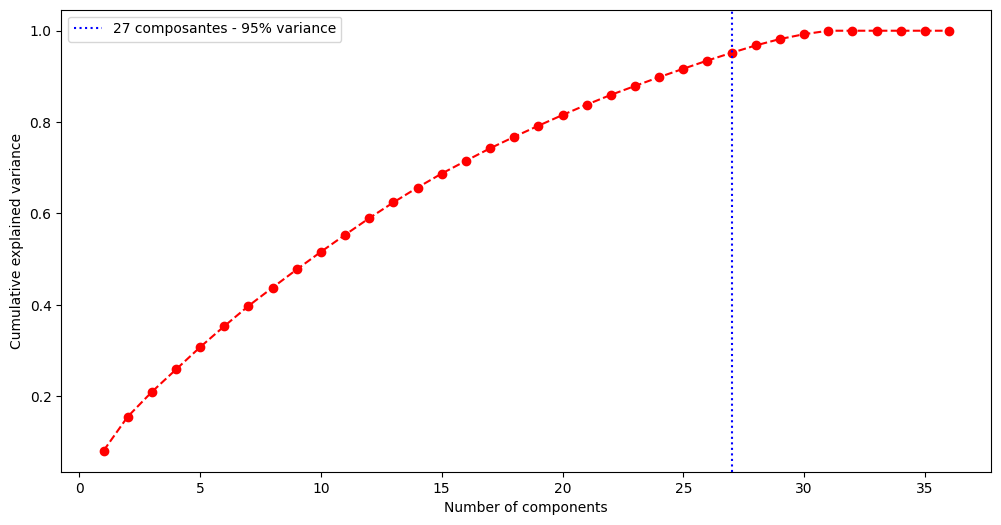

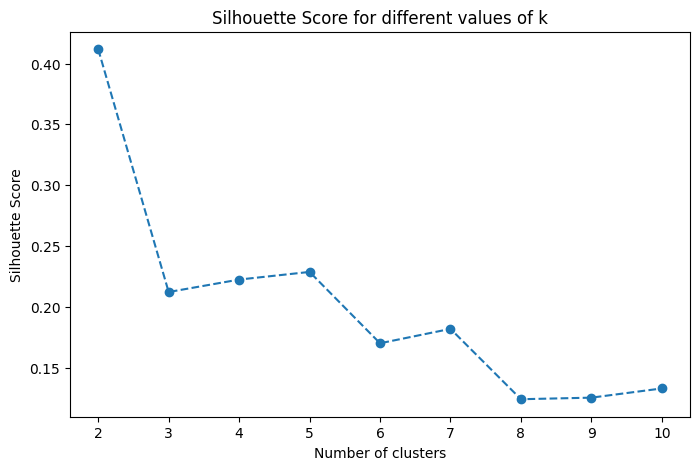

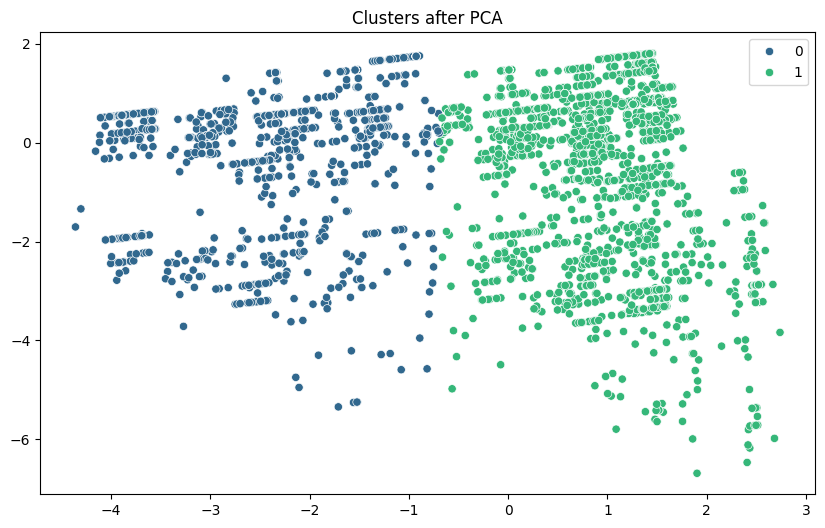

Silhouette Score BEFORE PCA: 0.4118
Silhouette Score AFTER PCA: 0.4778
✅PCA improves clustering!


In [4]:

df = pd.read_stata('HCMST_ver_3.04.dta')

columns_to_use = ['papreligion', 'papevangelical', 'q7b', 'q13a', 'relationship_quality', 'how_long_relationship', 'q24_met_online']
df_selected = df[columns_to_use].copy()

imputer = SimpleImputer(strategy='most_frequent')
df_selected.iloc[:, :] = imputer.fit_transform(df_selected)
df_selected = pd.DataFrame(df_selected, columns=columns_to_use)

ordinal_encoder = LabelEncoder()
df_selected['relationship_quality'] = ordinal_encoder.fit_transform(df_selected['relationship_quality'])

df_selected = pd.get_dummies(df_selected, columns=['papreligion', 'papevangelical', 'q7b', 'q13a', 'q24_met_online'], drop_first=False)

df_selected = df_selected.astype(float)
df_scaled = StandardScaler().fit_transform(df_selected)

n_components = df_scaled.shape[1]
pca = PCA(n_components=n_components, random_state=42)
X_pca = pca.fit_transform(df_scaled)

total_variance = sum(pca.explained_variance_)
variance_95 = total_variance * 0.95

# cumulative_variance = pca.explained_variance_.cumsum()
# optimal_components = (cumulative_variance < variance_95).sum() + 1

cumulative_variance = np.round(pca.explained_variance_ratio_.cumsum(), decimals=6)
optimal_components = np.argmax(cumulative_variance >= 0.95) + 1

plt.figure(figsize=(12, 6))
plt.plot(range(1, n_components + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--', color='r')
plt.axvline(optimal_components, linestyle=':', color='b', label=f'{optimal_components} composantes - 95% variance')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.legend()
plt.show()

silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(df_scaled)
    silhouette_scores.append(silhouette_score(df_scaled, clusters))

plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette_scores, marker='o', linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for different values of k')
plt.show()

k_best = K_range[silhouette_scores.index(max(silhouette_scores))]

kmeans_before_pca = KMeans(n_clusters=k_best, random_state=42)
clusters_before_pca = kmeans_before_pca.fit_predict(df_scaled)
score_before_pca = silhouette_score(df_scaled, clusters_before_pca)

variance_thresholds = [0.98, 0.99]

for threshold in variance_thresholds:
    optimal_components = np.argmax(pca.explained_variance_ratio_.cumsum() >= threshold) + 1
    pca = PCA(n_components=optimal_components, random_state=42)
    X_pca_reduced = pca.fit_transform(df_scaled)

    kmeans = KMeans(n_clusters=k_best, random_state=42)
    clusters_pca = kmeans.fit_predict(X_pca_reduced)
    score_pca = silhouette_score(X_pca_reduced, clusters_pca)

pca = PCA(n_components=max(2, optimal_components), random_state=42)
X_pca_reduced = pca.fit_transform(df_scaled)

kmeans = KMeans(n_clusters=k_best, random_state=42)
clusters = kmeans.fit_predict(X_pca_reduced)

df_selected['Cluster'] = clusters

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca_reduced[:, 0], y=X_pca_reduced[:, 1], hue=clusters, palette='viridis')
plt.title("Clusters after PCA")
plt.show()



kmeans_after_pca = KMeans(n_clusters=k_best, random_state=42)
clusters_after_pca = kmeans_after_pca.fit_predict(X_pca_reduced)
score_after_pca = silhouette_score(X_pca_reduced, clusters_after_pca)

print(f"Silhouette Score BEFORE PCA: {score_before_pca:.4f}")
print(f"Silhouette Score AFTER PCA: {score_after_pca:.4f}")

if score_after_pca > score_before_pca:
    print("✅PCA improves clustering!")
else:
    print("⚠️ PCA does not improve clustering, try multiple components or t-SNE.") 





### Check the Average Relationship Length per Cluster


In [5]:
average_relationship_length = df_selected.groupby("Cluster")["how_long_relationship"].mean()
print(average_relationship_length)

Cluster
0    16.366047
1    13.315312
Name: how_long_relationship, dtype: float64


### Check Meeting Methods Used per Cluster (Online vs. Traditional)

In [6]:
meeting_columns = [col for col in df_selected.columns if "q24_met_online" in col]

# Sum the meeting method distribution per cluster
meeting_methods = df_selected.groupby("Cluster")[meeting_columns].sum()

print(meeting_methods)

         q24_met_online_met offline  q24_met_online_met online
Cluster                                                       
0                            1143.0                       41.0
1                            2589.0                      229.0


C:\Users\ilasv\AppData\Local\Temp\ipykernel_4264\3824289183.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='how_long_relationship', data=df_selected, palette='coolwarm')


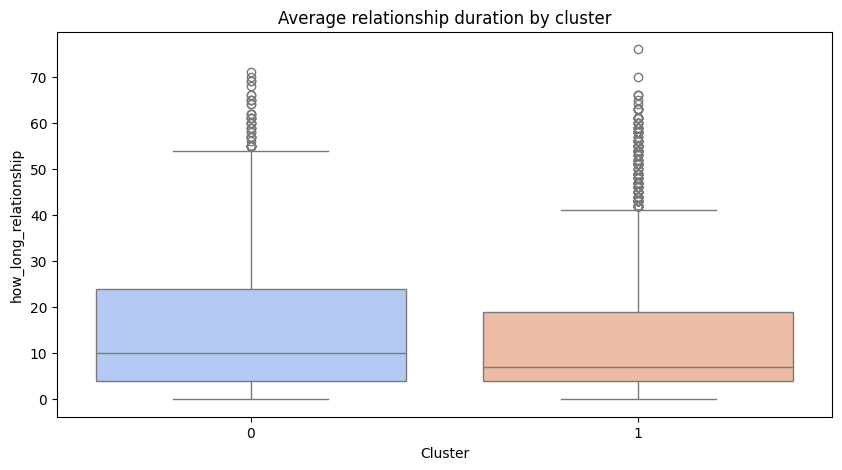

In [7]:

plt.figure(figsize=(10, 5))
sns.boxplot(x='Cluster', y='how_long_relationship', data=df_selected, palette='coolwarm')
plt.title('Average relationship duration by cluster')
plt.show()


C:\Users\ilasv\AppData\Local\Temp\ipykernel_4264\4041935074.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_religion_duration = df.groupby('papreligion')['how_long_relationship'].mean().reset_index()
C:\Users\ilasv\AppData\Local\Temp\ipykernel_4264\4041935074.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='papreligion', y='how_long_relationship', data=df_religion_duration, palette='viridis')


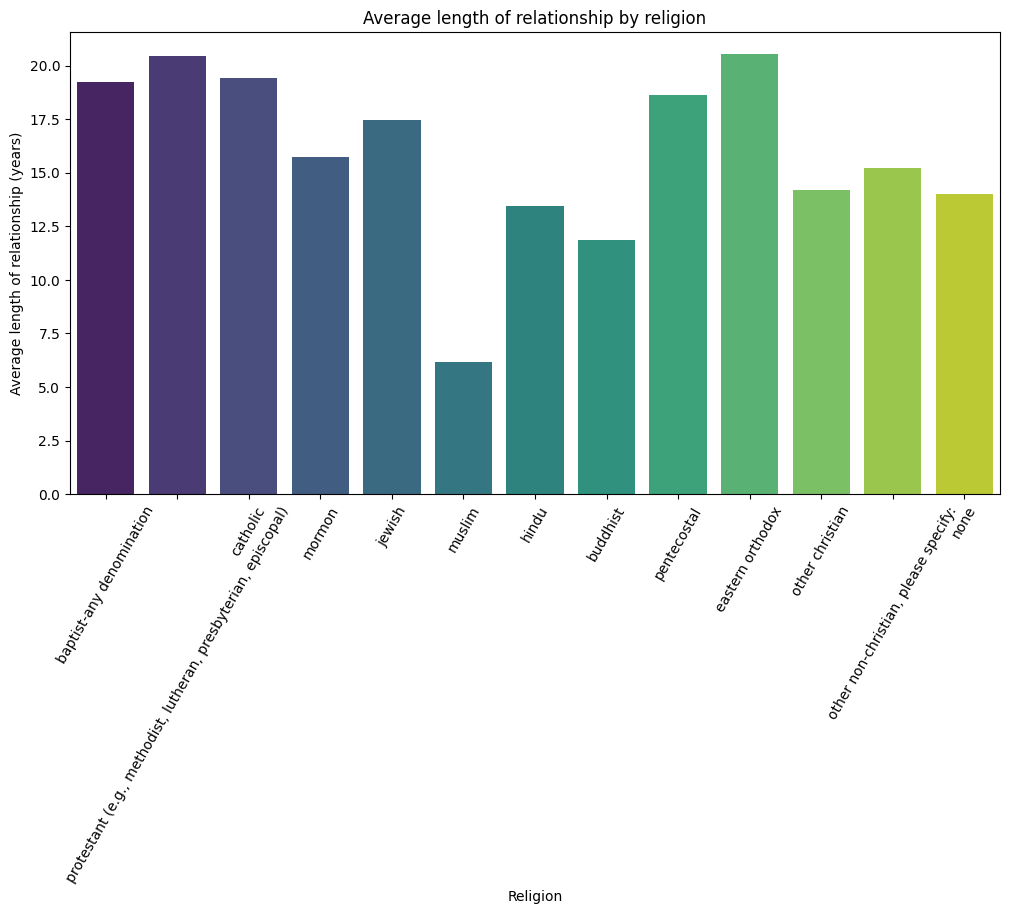

In [8]:

plt.figure(figsize=(12, 6))
df_religion_duration = df.groupby('papreligion')['how_long_relationship'].mean().reset_index()
sns.barplot(x='papreligion', y='how_long_relationship', data=df_religion_duration, palette='viridis')
plt.xticks(rotation=60)


plt.title('Average length of relationship by religion')
plt.xlabel('Religion')
plt.ylabel('Average length of relationship (years)')
plt.show()

In [9]:

print("\n📌 Conclusion and Interpretation:")
print("We have identified distinct groups of people based on their religiosity and relationship behavior.")

for cluster in df_selected['Cluster'].unique():
    avg_duration = df_selected[df_selected['Cluster'] == cluster]['how_long_relationship'].mean()
    avg_quality = df_selected[df_selected['Cluster'] == cluster]['relationship_quality'].mean()
    print(f"\nCluster {cluster}:")
    print(f"- Average relationship duration: {avg_duration:.2f} years")
    print(f"- Average relationship quality: {avg_quality:.2f}")
    print("---")

print("\n📌 Impact of Religiosity:")
duration_by_religion = df.groupby('papreligion')['how_long_relationship'].mean().to_dict()
for religion, duration in duration_by_religion.items():
    print(f"{religion}: Average relationship duration = {duration:.2f} years")

print("\nConclusion: The results suggest that religiosity influences both the method of meeting a partner and the duration of the relationship. More religious individuals seem to have longer relationships and tend to meet through more traditional methods. However, further analysis is needed to determine whether this effect is due to cultural, social, or personal factors.")



📌 Conclusion and Interpretation:
We have identified distinct groups of people based on their religiosity and relationship behavior.

Cluster 1:
- Average relationship duration: 13.32 years
- Average relationship quality: 0.58
---

Cluster 0:
- Average relationship duration: 16.37 years
- Average relationship quality: 0.54
---

📌 Impact of Religiosity:
baptist-any denomination: Average relationship duration = 19.24 years
protestant (e.g., methodist, lutheran, presbyterian, episcopal): Average relationship duration = 20.46 years
catholic: Average relationship duration = 19.44 years
mormon: Average relationship duration = 15.75 years
jewish: Average relationship duration = 17.46 years
muslim: Average relationship duration = 6.17 years
hindu: Average relationship duration = 13.47 years
buddhist: Average relationship duration = 11.85 years
pentecostal: Average relationship duration = 18.61 years
eastern orthodox: Average relationship duration = 20.54 years
other christian: Average relation

C:\Users\ilasv\AppData\Local\Temp\ipykernel_4264\377255797.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  duration_by_religion = df.groupby('papreligion')['how_long_relationship'].mean().to_dict()


##  Exploratory visualization

C:\Users\ilasv\AppData\Local\Temp\ipykernel_4264\1045873130.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='papreligion', data=df, order=df['papreligion'].value_counts().index, palette='coolwarm')


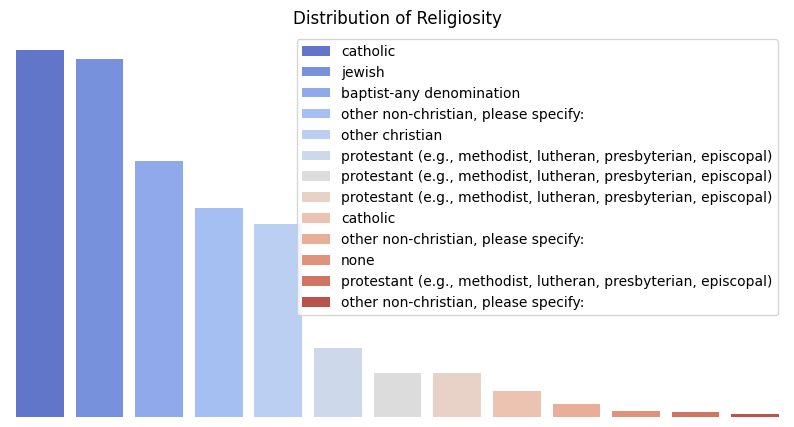

C:\Users\ilasv\AppData\Local\Temp\ipykernel_4264\1045873130.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='pppartyid3', data=df, order=df['pppartyid3'].value_counts().index, palette='coolwarm')


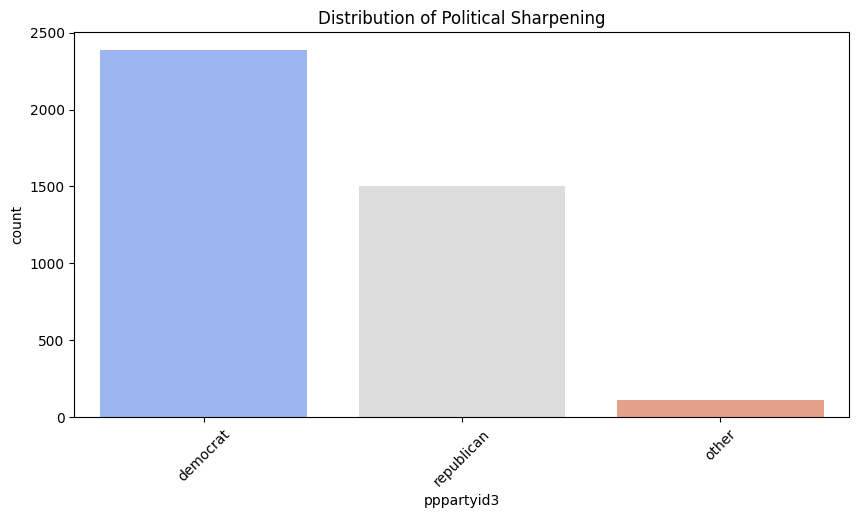

C:\Users\ilasv\AppData\Local\Temp\ipykernel_4264\1045873130.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='papreligion', y='how_long_relationship', data=df, palette='coolwarm')


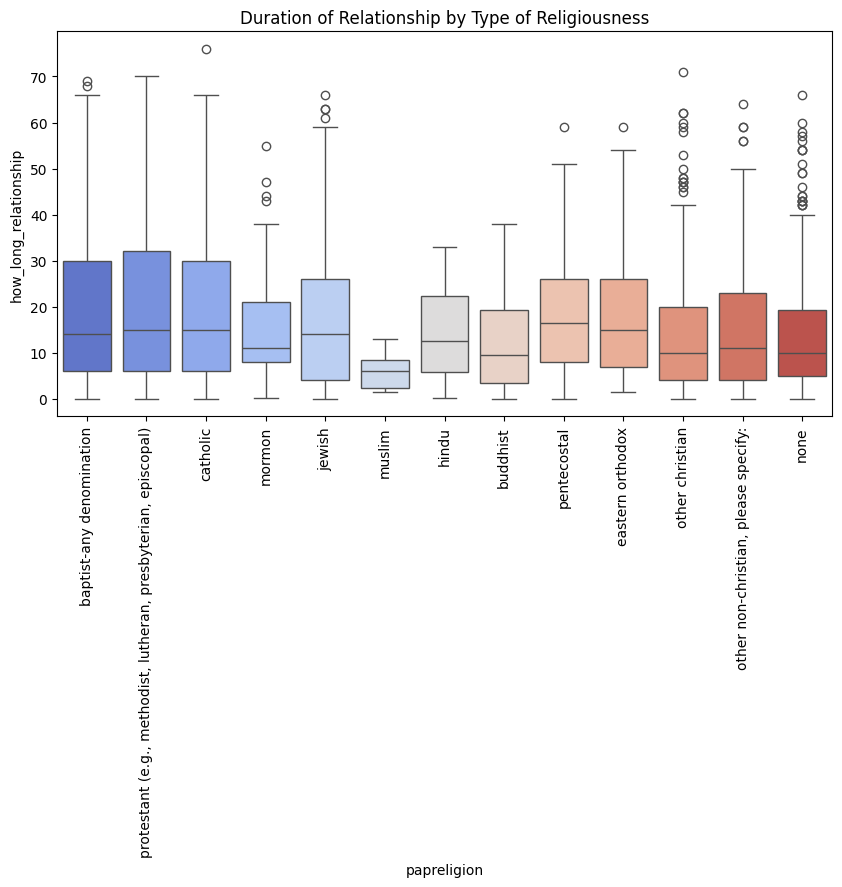

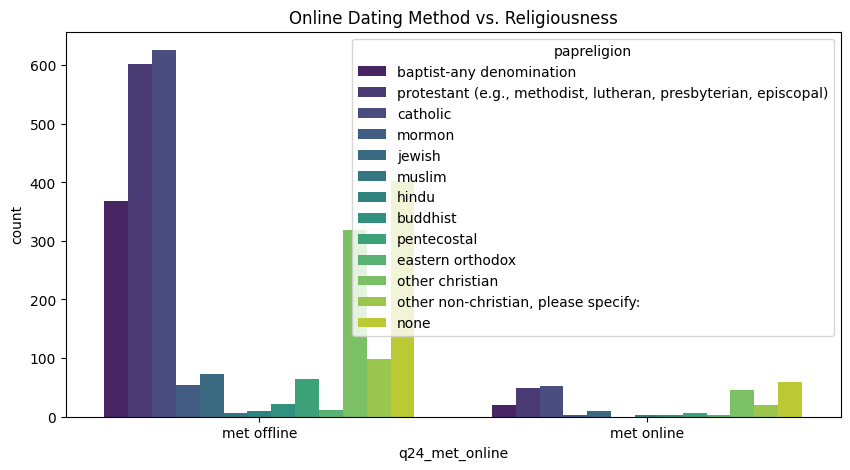

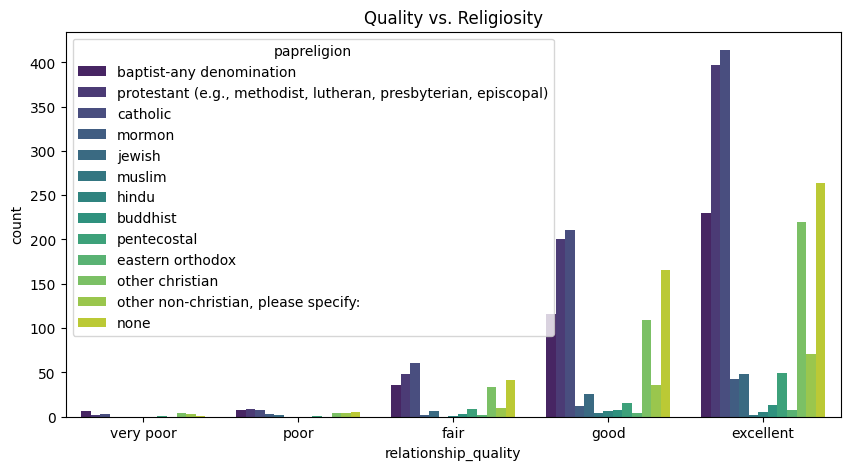

In [10]:

plt.figure(figsize=(10, 5))
sns.countplot(x='papreligion', data=df, order=df['papreligion'].value_counts().index, palette='coolwarm')
plt.xticks(rotation=45)
plt.title('Distribution of Religiosity')
plt.axis('off')
plt.legend(df['papreligion'])
plt.show()

plt.figure(figsize=(10, 5))
sns.countplot(x='pppartyid3', data=df, order=df['pppartyid3'].value_counts().index, palette='coolwarm')
plt.xticks(rotation=45)
plt.title('Distribution of Political Sharpening')
plt.show()


plt.figure(figsize=(10, 5))
sns.boxplot(x='papreligion', y='how_long_relationship', data=df, palette='coolwarm')
plt.xticks(rotation=90)
plt.title('Duration of Relationship by Type of Religiousness')
# plt.legend(df['papreligion'])
# plt.axis('off')
plt.show()


plt.figure(figsize=(10, 5))
sns.countplot(x='q24_met_online', hue='papreligion', data=df, palette='viridis')
plt.title('Online Dating Method vs. Religiousness')
plt.show()

plt.figure(figsize=(10, 5))
sns.countplot(x='relationship_quality', hue='papreligion', data=df, palette='viridis')
plt.title('Quality vs. Religiosity')
plt.show()
